In [2]:
# For autoreloading the classes so you do not need to restart the kernel
%load_ext autoreload
%autoreload 2

In [17]:
# Importing the libraries
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from sklearn.metrics import mean_squared_error
import sys
sys.path.append(os.path.abspath("../python"))

from EventReader import EventReader
from EventReader import show_data
from Model import SuperResolutionModel
from Model import create_datasets

In [4]:
r = 2.5 # radius of the detector in cm

In [5]:
# show data in directory
data_dir = '/mnt/c/Users/marjo/data/'
show_data(data_dir)

,subdir,detector,nevents,nphoton_per_event,set_no_scatter,set_experimental_scatter_model,radius
0,mc0000,XAMS,1000,100000,False,True,3.2
1,mc0001,XAMS,10000,10000,False,True,3.2
2,mc0002,XAMS,10000,10000,True,True,3.2
3,mc0003,XAMS,10000,10000,False,False,3.2
4,mc0004,XAMS,10000,10000,False,True,3.2
5,mc0005,XAMS,10000,10000,True,True,3.2


In [114]:
# read data
files = glob.glob(data_dir + 'mc0001/*0000.hd5f')
events = EventReader(files)

number of files:  1


In [115]:
# get the necessary information from the events
n = 0
nmax =10000 # if you do not want to loop over all events

true_pos = []
fine_top = []
top = []

for ev in events:
    if n%1000 == 0:
        print('processed ', n, 'events')
    n+=1
    
    # retrieve the true hit position
    truth = ev['true_position']
    true_pos.append(truth)
                    
    # get the data from the top PMT    
    pmt = ev['pmt_top'][()]
    top.append(pmt.T)
    fine_pmt = ev['fine_top'][()]
    fine_top.append(fine_pmt.T)

    if n>=nmax:
        print('processed ', nmax, 'events')
        break

events.reset()

processed  0 events
processed  1000 events
processed  2000 events
processed  3000 events
processed  4000 events
processed  5000 events
processed  6000 events
processed  7000 events
processed  8000 events
processed  9000 events
processed  10000 events


In [116]:
print(f"We have {len(top)} events")
print(f"low res PMT has shape {top[0].shape}")
print(f"high res truth has shape {fine_top[0].shape}")
print(f"true positions have shape {true_pos[0].shape}")

We have 10000 events
low res PMT has shape (2, 2)
high res truth has shape (20, 20)
true positions have shape (3,)


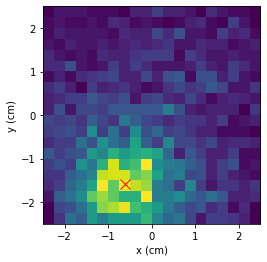

In [117]:
# check if data is ok
num = 1
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.imshow(
    top[num], interpolation="nearest", origin="lower", extent=[-r, r, -r, r]
)
ax.imshow(
    fine_top[num],
    interpolation="nearest",
    origin="lower",
    extent=[-2.5, 2.5, -2.5, 2.5],
)
ax.plot(
    true_pos[num][0],
    true_pos[num][1],
    marker="x",
    markersize=10,
    color="red",
    label="true position",
)
plt.xlabel("x (cm)")
plt.ylabel("y (cm)")
plt.show()

In [118]:
def downsample_heatmaps_to_dimensions(heatmaps, new_height, new_width):
    """
    Downsample a list of heatmaps to specified dimensions using averaging.

    Args:
        heatmaps (list of numpy.ndarray): List of high-resolution heatmaps.
        new_height (int): The desired height of the downsampled heatmaps.
        new_width (int): The desired width of the downsampled heatmaps.

    Returns:
        list of numpy.ndarray: List of downsampled heatmaps.
    """
    downsampled_heatmaps = []

    for heatmap in heatmaps:
        # Get the dimensions of the original heatmap
        height, width = heatmap.shape

        # Reshape the heatmap to a 4D tensor for pooling
        heatmap_4d = heatmap.reshape((1, 1, height, width))

        # Calculate the scale factors for downsampling
        scale_factor_height = height // new_height
        scale_factor_width = width // new_width

        # Perform average pooling using np.mean
        downsampled_heatmap_4d = np.mean(heatmap_4d.reshape((1, 1, new_height, scale_factor_height, new_width, scale_factor_width)), axis=(3, 5))

        # Reshape the downsampled heatmap to the desired dimensions
        downsampled_heatmap = downsampled_heatmap_4d.reshape((new_height, new_width))

        downsampled_heatmaps.append(downsampled_heatmap)

    return np.asarray(downsampled_heatmaps)

In [119]:
# create train and test sets
y = np.asarray(fine_top)
X = np.asarray(top)
pos = [pos[:2] for pos in true_pos] # depth is not used

X_train, y_train, pos_train, X_test, y_test, pos_test = create_datasets(
    X, y, pos, train_fraction=0.8
)
y_train_downsampled = downsample_heatmaps_to_dimensions(y_train, 5, 5)
y_test_downsampled = downsample_heatmaps_to_dimensions(y_test, 5, 5)

In [120]:
# define weighted average estimate
def weighted_average_estimator(X):
    """Estimate the position of the event by taking the weighted average of the PMTs.
    The weights are the relative PMT charge.
    """
    x = (-r*X[:,0,0] + r*X[:,0,1] - r*X[:,1,0] + r*X[:,1,1])/np.sum(X, axis=(1,2))
    y =(-r*X[:,0,0] - r*X[:,0,1] + r*X[:,1,0]+ r*X[:,1,1])/np.sum(X, axis=(1,2))
    return list(zip(x,y))
    
wa_pred = weighted_average_estimator(X_test)
wa_mse = mean_squared_error(pos_test, wa_pred)


In [121]:
# load the trained models
with open('model1.pkl', 'rb') as f:
    model1 = pickle.load(f)

with open('model2.pkl', 'rb') as f:
    model2 = pickle.load(f)

In [122]:
print(f"MSE weighted average estimator: {wa_mse}")
print(f"model1: {model1.evaluate(X_test, y_test, pos_test)}")
print(f"model2: {model2.evaluate(X_test, y_test_downsampled, pos_test)}")

MSE weighted average estimator: 0.542063452684799
model1: {'MSE': 5593.618256883456, 'R^2': -2160.8745783052723}
model2: {'MSE': 4252.7578992086355, 'R^2': -1642.646163853266}


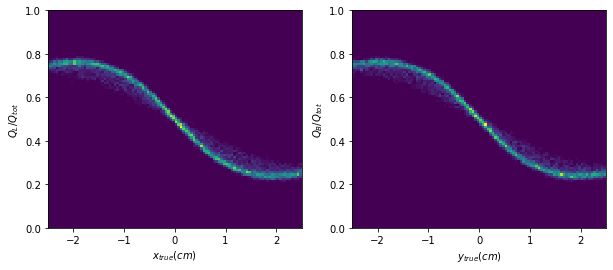

In [123]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

qtot = np.sum(np.asarray(X), axis=(1,2))
q_tb = ((np.asarray(X)[:,0,0]+np.asarray(X)[:,0,1])/qtot)
q_lr = ((np.asarray(X)[:,0,0]+np.asarray(X)[:,1,0])/qtot)

h1 = axs[0].hist2d(np.asarray(true_pos)[:,0],q_lr,bins=(100,100), range=((-r,r),(0,1)))
axs[0].set_xlabel('$x_{true} (cm)$')
axs[0].set_ylabel('$Q_L / Q_{tot}$')

h2 = axs[1].hist2d(np.asarray(true_pos)[:,1],q_tb,bins=(100,100), range=((-r,r),(0,1)))
axs[1].set_xlabel('$y_{true} (cm)$')
axs[1].set_ylabel('$Q_B / Q_{tot}$')
plt.show()

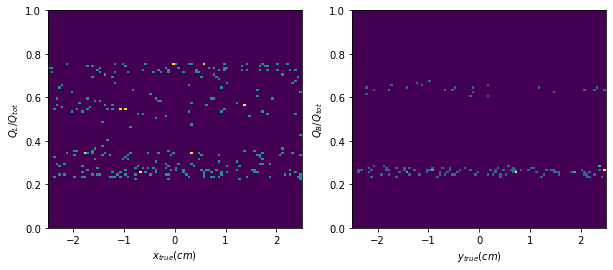

In [124]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

qtot = np.sum(np.asarray(X_train), axis=(1,2))
q_tb = ((np.asarray(X_train)[:,0,0]+np.asarray(X_train)[:,0,1])/qtot)
q_lr = ((np.asarray(X_train)[:,0,0]+np.asarray(X_train)[:,1,0])/qtot)

pred_pos = model1.predict(X_train)

h1 = axs[0].hist2d(np.asarray(pred_pos)[:,0],q_lr,bins=(100,100), range=((-r,r),(0,1)))
axs[0].set_xlabel('$x_{true} (cm)$')
axs[0].set_ylabel('$Q_L / Q_{tot}$')

h2 = axs[1].hist2d(np.asarray(pred_pos)[:,1],q_tb,bins=(100,100), range=((-r,r),(0,1)))
axs[1].set_xlabel('$y_{true} (cm)$')
axs[1].set_ylabel('$Q_B / Q_{tot}$')
plt.show()

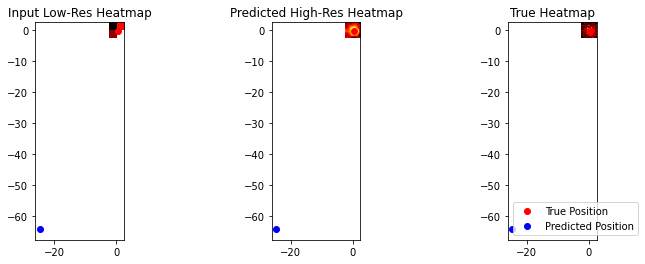

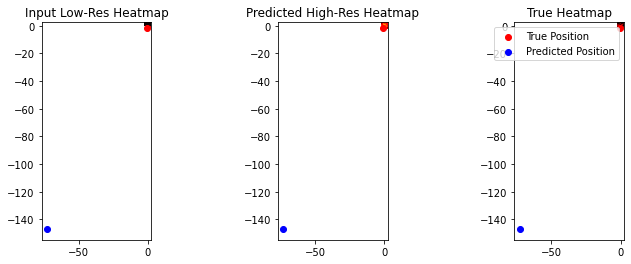

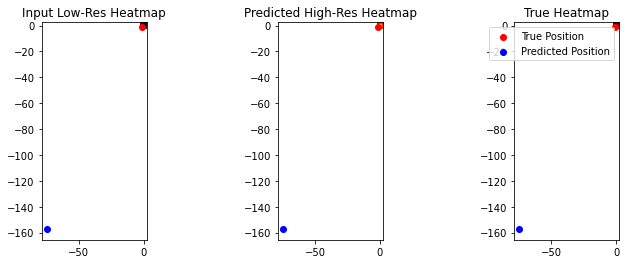

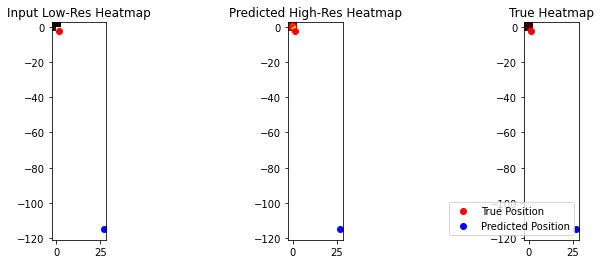

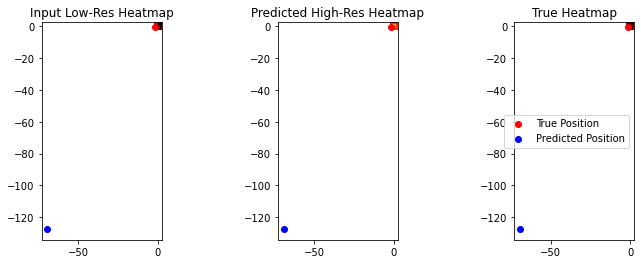

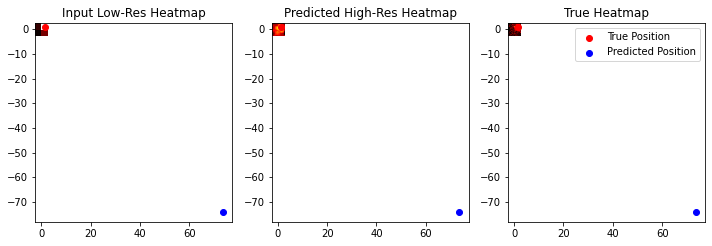

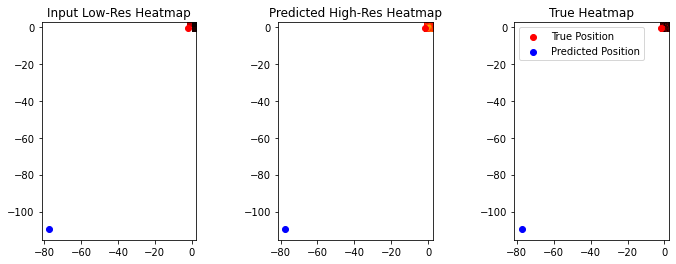

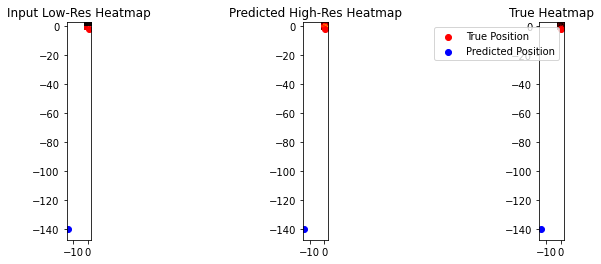

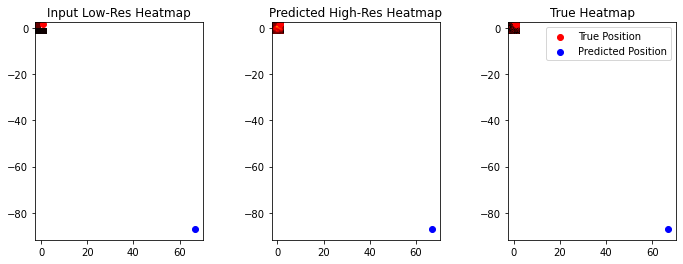

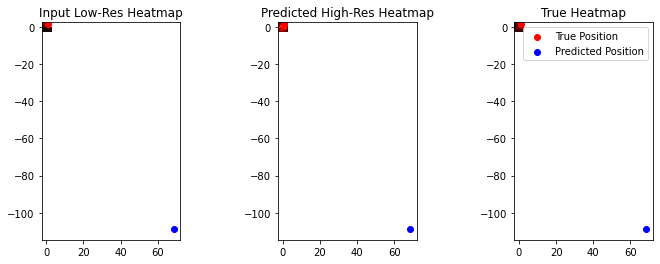

In [125]:
model1.visualize_heatmaps_with_positions(X_train, y_train, pos_train)

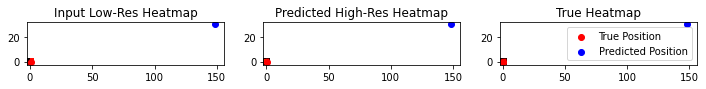

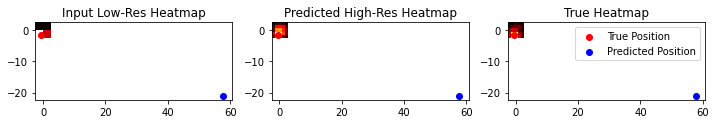

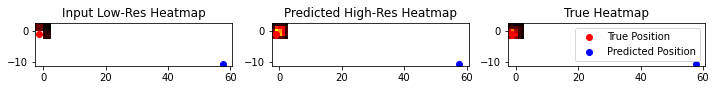

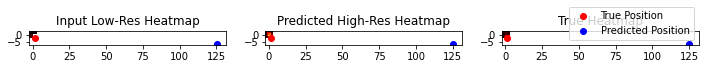

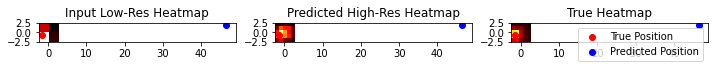

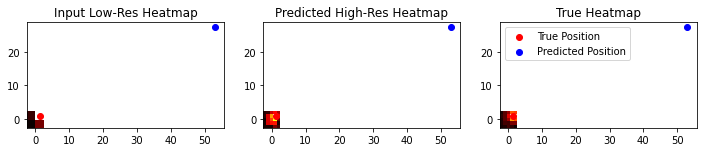

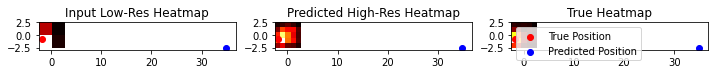

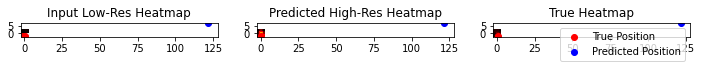

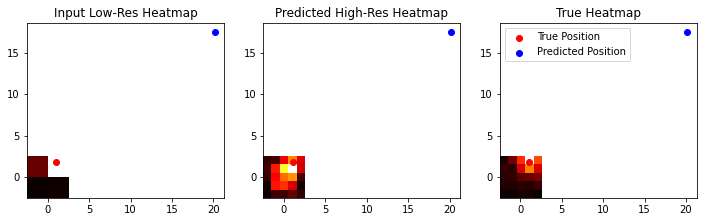

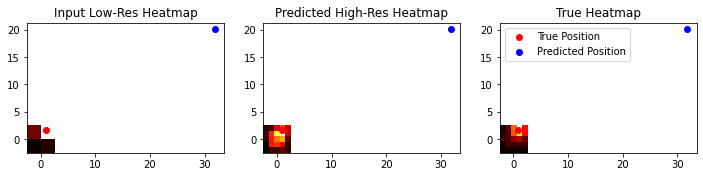

In [126]:
model2.visualize_heatmaps_with_positions(X_train, y_train_downsampled, pos_train)